In [1]:
import os
from datetime import datetime
# Essential Libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import r2_score
import sqlite3

# Liste des fonctions

## f_requete_sql - Requete SQL

In [2]:
def f_requete_sql (requete) :
    try:
        connexion = sqlite3.connect('./data/liste_piezos.db')
        curseur = connexion.cursor()
        print("Connexion réussie à SQLite")
        curseur.execute(requete)
        connexion.commit()
        resultat = curseur.fetchall()
        curseur.close()
        connexion.close()
        print("Connexion SQLite est fermée")
        return resultat
    except sqlite3.Error as error:
        print("Erreur lors du mis à jour dans la table", error)

## f_clusters_transform - Fonction conversion df en np.array

In [3]:
def f_clusters_transform (df):
    """
    df : dataframe pandas
    """
    data = df.values.T
    names = df.columns
    return(data, names)

## f_clusters_coude - Fonction d'affichage de l'inertie en fonction du nombre de clusters

In [4]:
def f_clusters_coude (df, k_max:int=15):
    """
    k_max : entier représentant le nombre max de clusters à tracer
    """
    data, names = f_clusters_transform(df)
    Sum_of_squared_distances = [] 
    K = range(1,30) 
    for k in K : 
        km = KMeans(n_clusters=k) 
        km = km.fit(data) 
        Sum_of_squared_distances.append(km.inertia_)

    plt.plot(K, Sum_of_squared_distances, 'bx-') 
    plt.xlabel('k') 
    plt.ylabel('Sum_of_squared_distances') 
    plt.title('Méthode du coude pour k optimal') 
    plt.show()

## f_clusters_fit - Fonction entrainement du modèle, retour des labels et profils clusters

In [5]:
def f_clusters_fit (df, k:int = 4, n_init:int = 200, max_iter:int = 1000):
    """
    Entrainement et affichage de la distribution dans les clusters
    return :
    - cluster_table : df bss - cluster - r2
    - df_clusters_centers : df série temporelle des clusters
    """
    data, names = f_clusters_transform (df)
    km = KMeans(n_clusters=k, n_init=200, max_iter=1000)
    # Entraînement du modèle
    km.fit(data)
    # Définition des numéros de cluster
    labels = km.labels_+1
    # Profils des clusters
    cluster_centers = np.array(km.cluster_centers_)
    df_cluster_centers = pd.DataFrame(cluster_centers.T, index=df.index)
    for cluster in range(df_cluster_centers.shape[1]):
        df_cluster_centers.rename(columns = {cluster:f"cluster_{cluster+1}"}, inplace=True)
    
    # Création du dataframe de résultats
    cluster_table = pd.DataFrame()
    cluster_table["code_bss"] = names
    cluster_table.set_index("code_bss", inplace=True)
    cluster_table["cluster"] = labels
    for piezo in cluster_table.index :
        cluster_table.loc[piezo, "r2"] = r2_score(df.loc[:,piezo], cluster_centers[cluster_table.loc[piezo, "cluster"]-1])
    
    return cluster_table, df_cluster_centers

## f_plot_clusters - Fonction d'affichage des chroniques par cluster

In [6]:
def f_plot_clusters (df, cluster_table, cluster_centers):
    
    data, names = f_clusters_transform (df)
    
    labels = cluster_table["cluster"]
    
    fig, axs = plt.subplots(len(set(labels)),1,figsize=(20,25))
    row_i=0

    for label in set(labels):
        for i in range(len(labels)):
            if(labels[i]==label):
                axs[row_i].plot(df.iloc[:,i],alpha=0.4)

        axs[row_i].plot(cluster_centers.iloc[:,label-1],c="red")
        axs[row_i].set_title("Cluster "+str(row_i+1))
        row_i+=1
    plt.show()

## f_plot_all - Fonction d'affichage individuel des chroniques et leur cluster associé

In [7]:
def f_plot_all (df, cluster_table, df_cluster_centers) :

    data, names = f_clusters_transform (df)

    if df.shape[1]%4 == 0:
        nbre_lignes = df.shape[1]//4
    else : 
        nbre_lignes = df.shape[1]//4 + 1

    fig, axs = plt.subplots(nbre_lignes,4,figsize=(25,200))
    #fig.suptitle('Series')
    for i in range(nbre_lignes):
        for j in range(4):
            if i*4+j+1>df.shape[1]: # pass the others that we can't fill
                continue
            axs[i, j].plot(df.iloc[:,i*4+j])
            axs[i, j].plot(df_cluster_centers.iloc[:,cluster_table.iloc[i*4+j,0]-1])
            
            axs[i, j].set_title(df.columns[i*4+j] + f" - r² = {round(cluster_table.loc[df.columns[i*4+j],'r2'],2)}")
            
    plt.show()

## f_r2min - Fonction de calcul du seuil minimal r2

In [8]:
def f_r2min (cluster_table):
    # Calcul de r2min

    Q1 = cluster_table["r2"].quantile(0.25, "higher")
    Q3 = cluster_table["r2"].quantile(0.75, "lower")

    # Ecart inter-quartile
    IQM = (Q3-Q1)

    # Seuil minimal de conservation des chroniques (Q1-1.5*IQM)

    r2min = Q1-1.5*IQM
    return r2min

# Exploitation

## Chargement des données

In [9]:
region = "IDF"

In [10]:
# Import du csv et conversion en dataframe
custom_date_parser = lambda x: datetime.strptime(x, "%Y-%m-%d")
data = pd.read_csv(f"./data/piezo_clustering/{region}.csv", sep = ";", parse_dates=True, index_col="date_mesure", date_parser=custom_date_parser)

## Analyse du nombre optimal de clusters

C:\Users\daranlot\Anaconda3\envs\Environnement\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


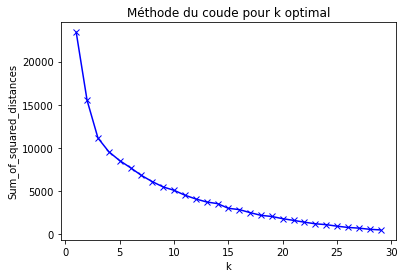

In [11]:
f_clusters_coude(data)

In [13]:
nbre_clusters = 5

## Création des clusters

In [14]:
cluster_table, cluster_centers = f_clusters_fit(data, nbre_clusters, 1000, 8000)

C:\Users\daranlot\Anaconda3\envs\Environnement\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='cluster', ylabel='count'>

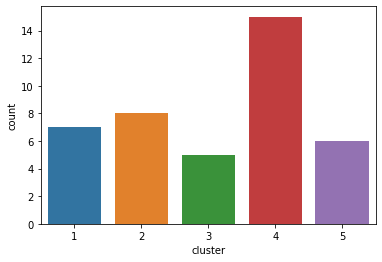

In [15]:
sns.countplot(cluster_table.cluster)

In [16]:
# On renomme les noms de cluster par rapport à la région
for index, column in enumerate (cluster_centers.columns):
    cluster_centers.rename(columns={column : f"{region}_{index+1}"}, inplace=True)

In [17]:
cluster_centers.head()

IDF_1     IDF_2     IDF_3     IDF_4     IDF_5
date_mesure                                                  
2004-12-17  -0.667030  2.000906  0.574902 -0.155037 -1.863566
2004-12-24  -0.383037  1.959177  0.755686 -0.194403 -1.858380
2004-12-31  -0.409666  1.905023  0.648178 -0.228917 -1.749968
2005-01-07  -0.388185  1.913977  0.707837 -0.208334 -1.828892
2005-01-14  -0.449001  1.938910  0.753798 -0.205872 -1.906265

## Affichage des clusters

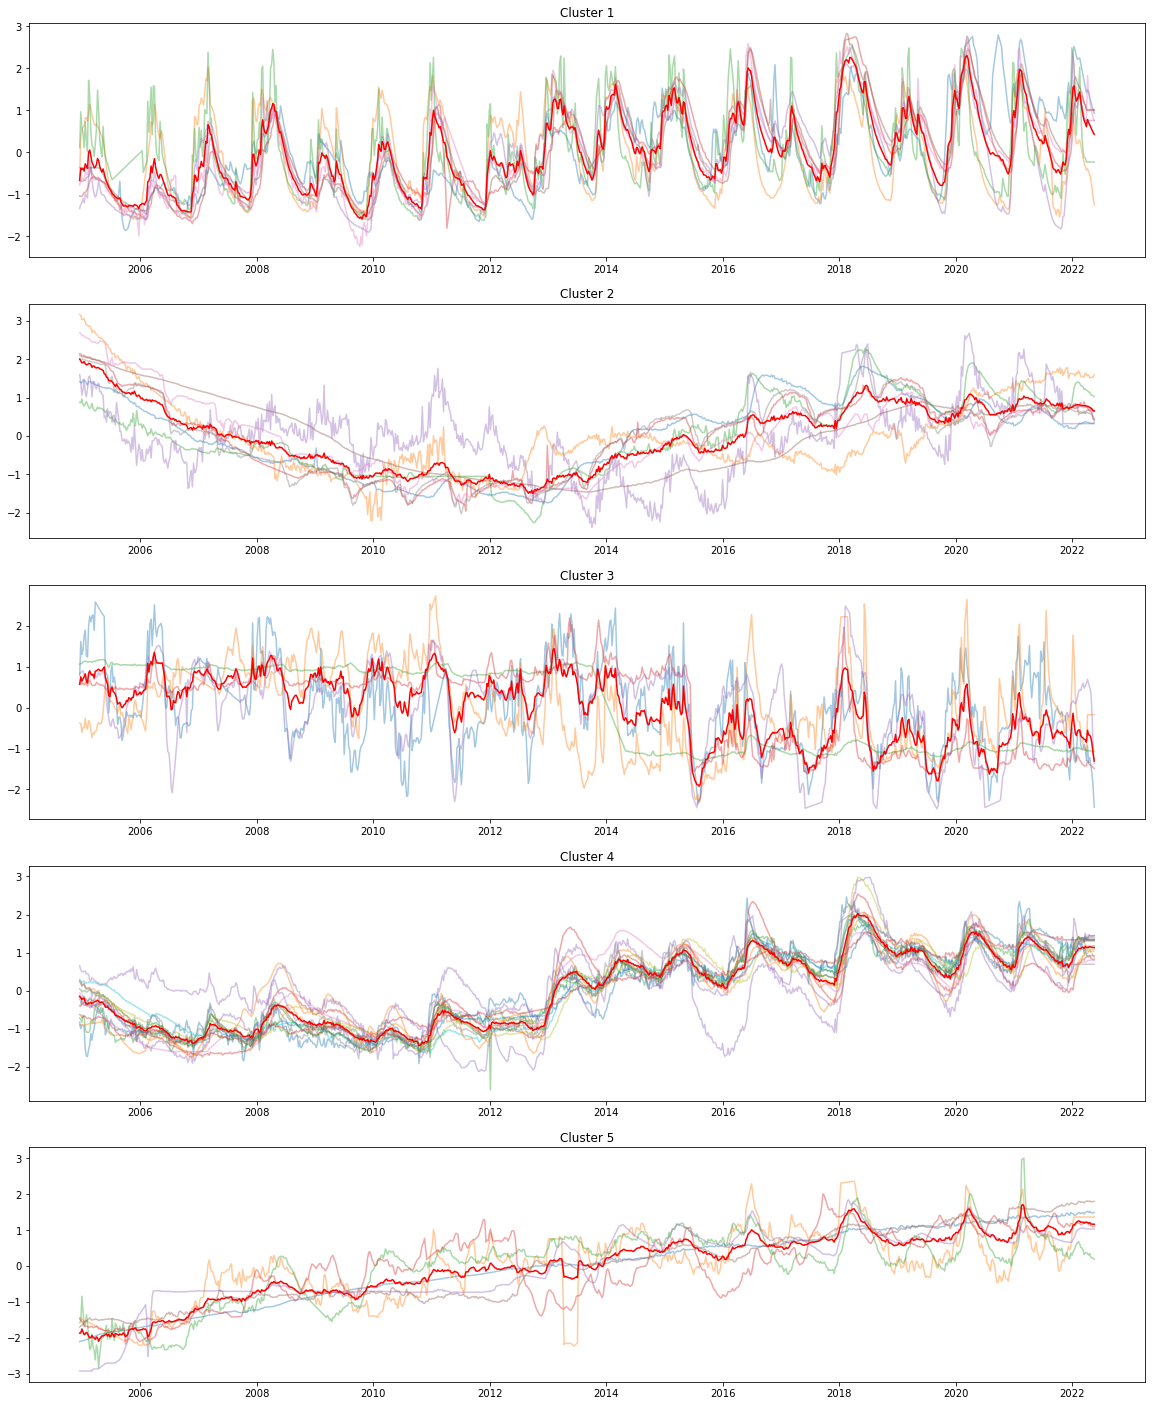

In [18]:
f_plot_clusters(data, cluster_table, cluster_centers)

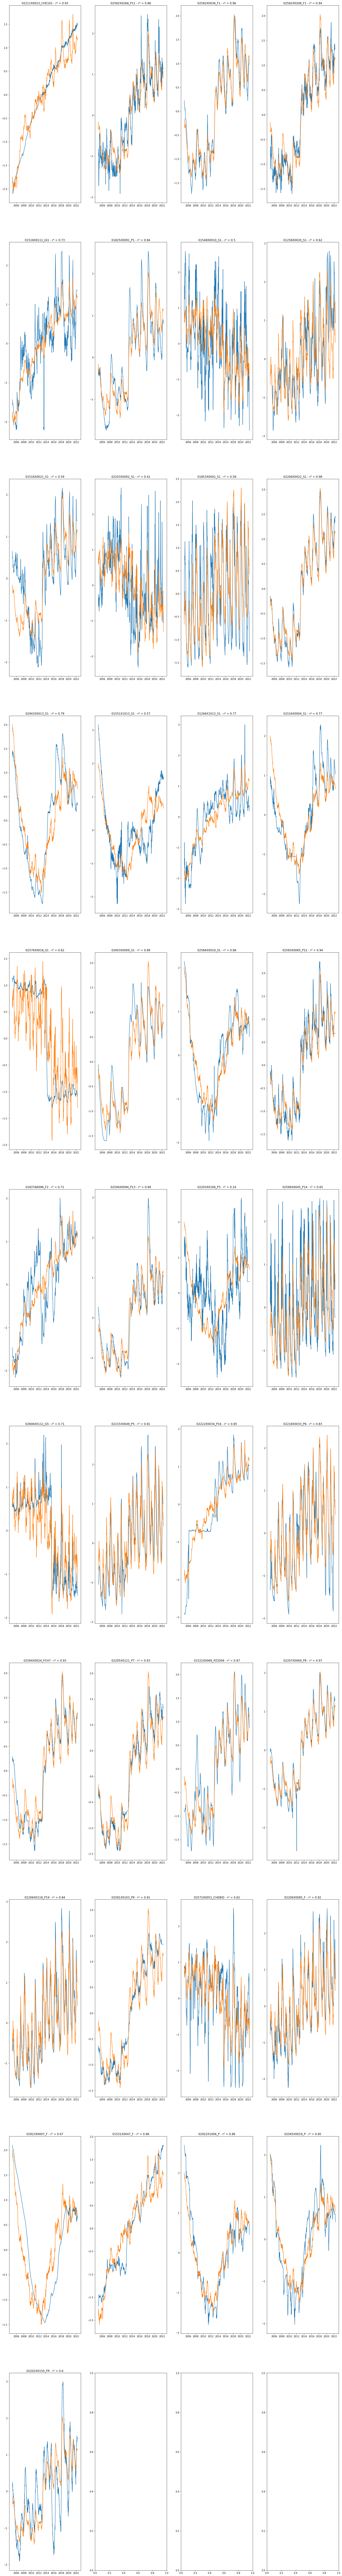

In [19]:
f_plot_all(data, cluster_table, cluster_centers)

## Analyse r2

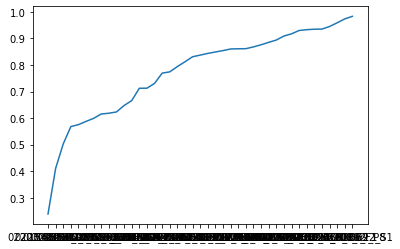

In [20]:
plt.plot(cluster_table["r2"].sort_values())

## Filtre des chroniques avec score insuffisant

In [21]:
# nbre de chroniques sous le seuil
r2min = f_r2min(cluster_table)
nbre_elim = cluster_table.loc[cluster_table.r2 < r2min, 'r2'].count()
iteration = 1

while nbre_elim != 0 :
    # chroniques sous le seuil passées à cluster 0
    r2min = f_r2min(cluster_table)
    cluster_table.loc[cluster_table.r2 < r2min, "cluster"] = 0
    
    # Selection des clusters non zéro
    data = data.loc[:,cluster_table.loc[cluster_table.cluster != 0].index]
    
    # Nouveau clustering
    cluster_table, cluster_centers = f_clusters_fit(data, nbre_clusters, 1000, 8000)
    
    nbre_elim = cluster_table.loc[cluster_table.r2 < r2min, 'r2'].count()
    
    print(f"Itération {iteration} : {nbre_elim} chronique(s) éliminée(s).")
    iteration += 1
    

Itération 1 : 0 chronique(s) éliminée(s).


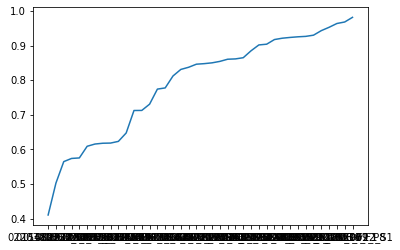

In [22]:
plt.plot(cluster_table["r2"].sort_values())

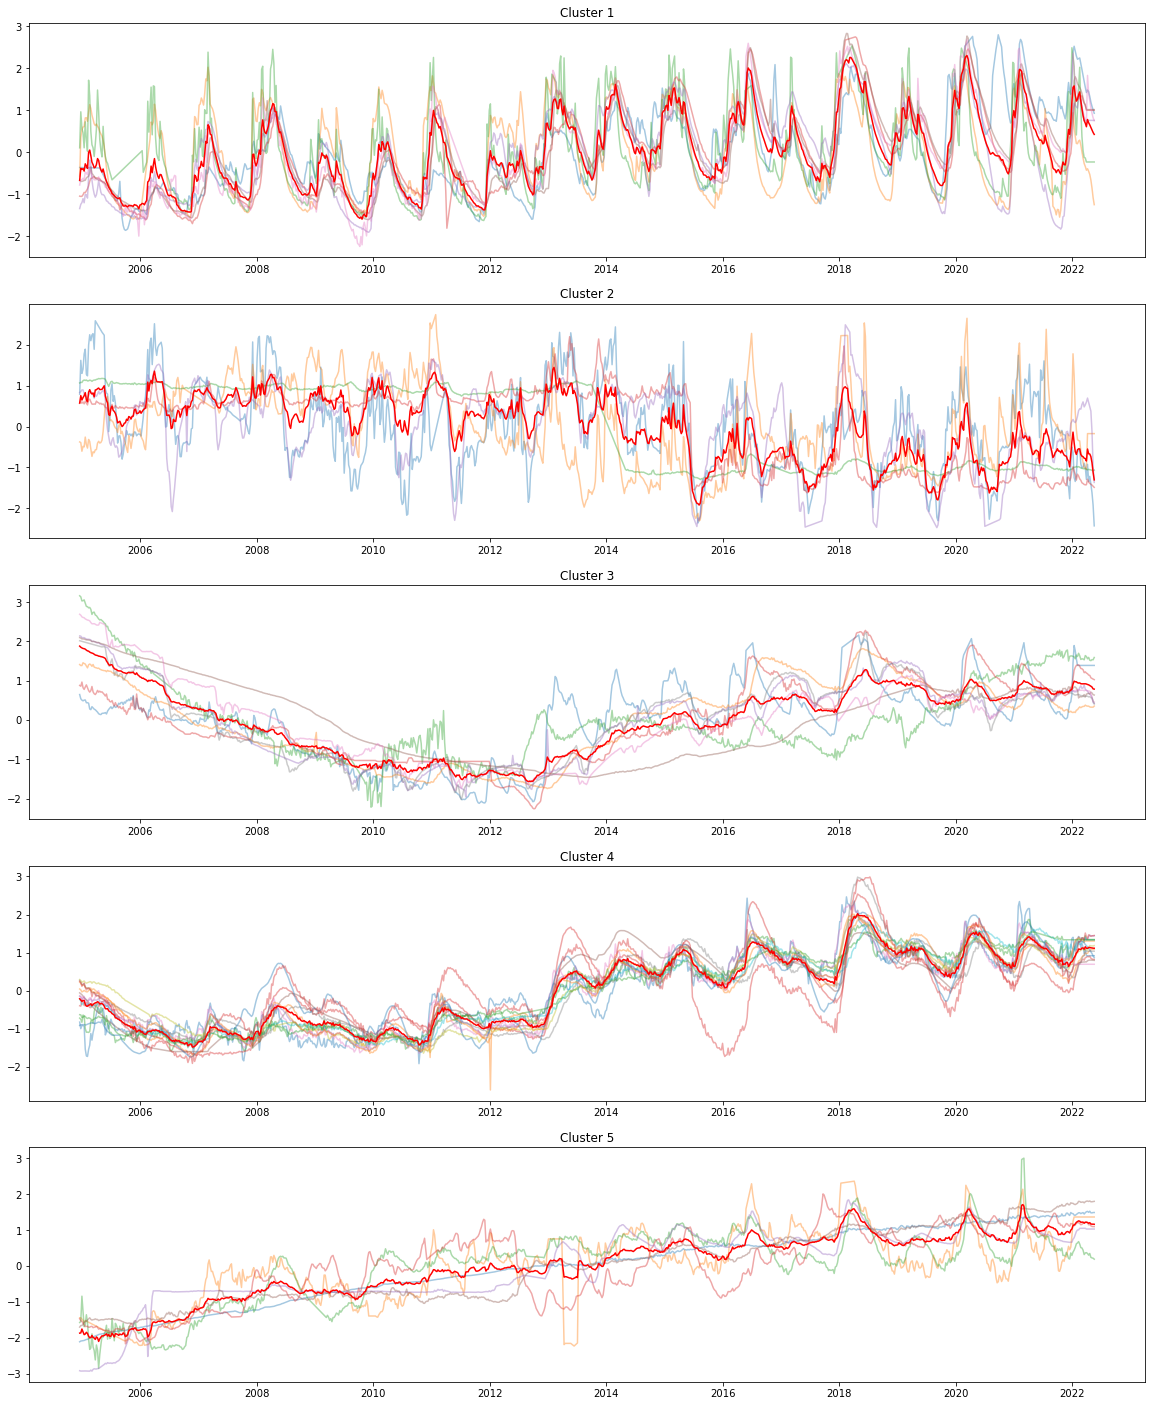

In [23]:
f_plot_clusters(data, cluster_table, cluster_centers)

<AxesSubplot:xlabel='date_mesure'>

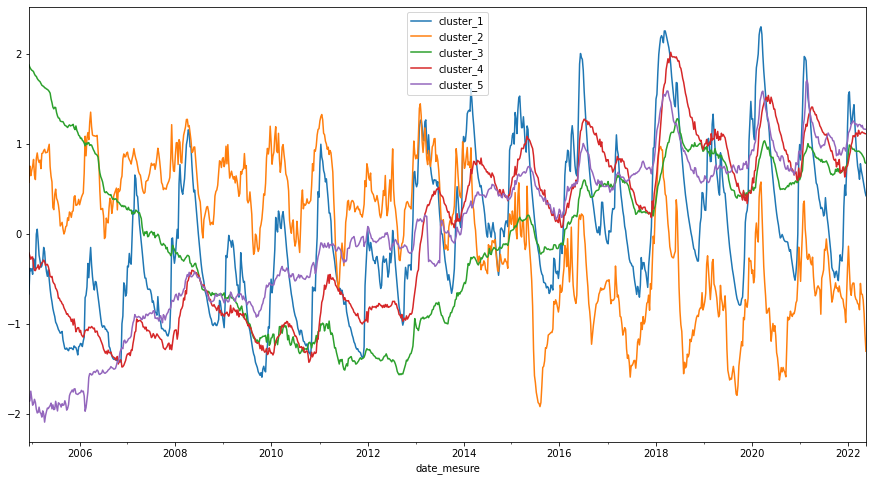

In [24]:
cluster_centers.plot(figsize=(15,8))

In [25]:
cluster_table.sort_values(by='r2').head()

cluster        r2
code_bss                        
02203X0002_S1        2  0.410730
01548X0010_S1        2  0.502956
01551X1013_S1        3  0.564848
02923X0007_F         3  0.574047
01853X0002_S1        1  0.575535

# Ajout à la bdd

In [26]:
data.to_csv(f"./data/piezo_clustering/{region}.csv", sep = ";")

In [27]:
cluster_centers.to_csv(f"./data/piezo_clustering/{region}_clusters.csv", sep = ";")

In [28]:
requete = """
                    ALTER TABLE data_piezo
                    ADD cluster_sklearn_kmeans_5_v1 VARCHAR(6) DEFAULT NULL
                    """
f_requete_sql(requete)

Connexion réussie à SQLite
Erreur lors du mis à jour dans la table duplicate column name: cluster_sklearn_kmeans_5_v1


In [29]:
# Création de listes de nuéro de cluster avec le nom des piezos
# Ajout dans la bdd
for label in set(cluster_table.cluster):
    exec(f'cluster = tuple(cluster_table.loc[cluster_table.cluster == {label}, "cluster"].index.to_list())')
    requete = f"""
        UPDATE data_piezo
        SET cluster_sklearn_kmeans_5_v1 = '{region + "_" + str(label)}'
        WHERE code_bss IN {cluster}
        """
    f_requete_sql(requete)

Connexion réussie à SQLite
Connexion SQLite est fermée
Connexion réussie à SQLite
Connexion SQLite est fermée
Connexion réussie à SQLite
Connexion SQLite est fermée
Connexion réussie à SQLite
Connexion SQLite est fermée
Connexion réussie à SQLite
Connexion SQLite est fermée


## Suppresion colonne

In [ ]:
requete = """
                    ALTER TABLE data_piezo
                    DROP cluster_sklearn_kmeans_5_v1
                    """
f_requete_sql(requete)